# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
from IPython.display import display_markdown
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import time

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
def show_info(df):
    display_markdown('### Первые 5 строк данных', raw=True)
    display(df.head())
    display_markdown('### Информация о датафрейме', raw=True)
    display(df.info())
    display_markdown('### Количество пропусков',  raw=True)
    display(df.isna().sum())
    display_markdown('### Количество дубликатов', raw=True)
    display(df.duplicated().sum())
    display_markdown('### Статистика столбцов', raw=True)
    display(df.describe())

In [4]:
show_info(data)

### Первые 5 строк данных

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

### Количество пропусков

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Количество дубликатов

4

### Статистика столбцов

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Удалим неинформативные столбцы

Удалим те колонки, содержимое которых не влияет на цену автомобиля:

- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [5]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Заполним пропуски

Пропуски в колонках VehicleType, Gearbox, Model, FuelType, Repaired заполним заглушками, так как нет никакой логики, по которой мы могли бы восстановить пропущенные данные.

In [6]:
def fill(column):
    column.fillna('unknown', inplace = True)

In [7]:
for column in [data['VehicleType'], data['Gearbox'], data['Model'], data['FuelType'], data['Repaired']]:
    fill(column)

In [8]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

### Удалим дубликаты

Посмотрим, сколько стало дубликатов после удаления столбцов

In [9]:
data.duplicated().sum()

45040

Мы понимаем, что автомобили разные, но модели дубликаты не пойдут на пользу, поэтому удалим их

In [11]:
data = data.drop_duplicates()

In [12]:
data.duplicated().sum()

0

### Обработаем аномалии

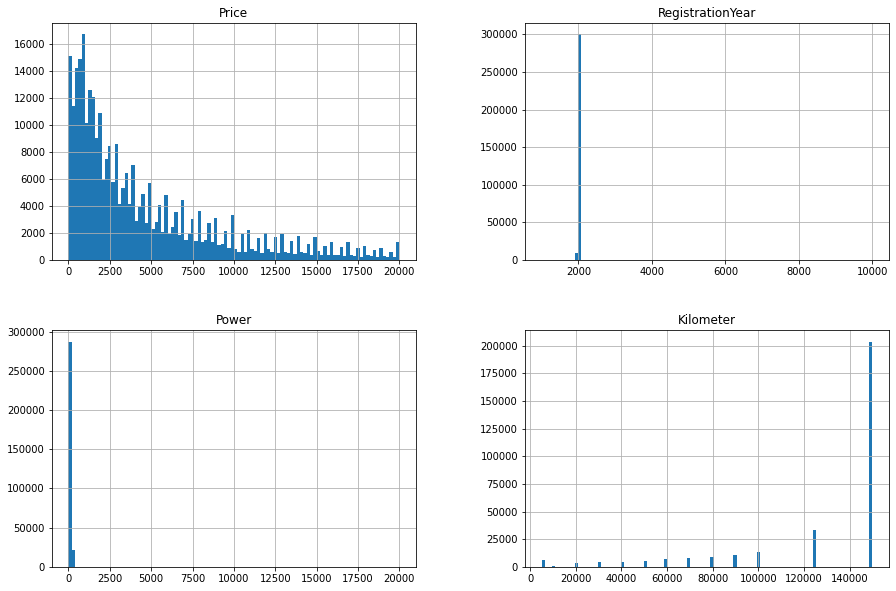

In [13]:
data.hist(figsize=(15, 10), bins=100);

В колонкe Kilometer все хорошо, а колонки Price, Power и RegistrationYear рассмотрим поближе.

#### Колонка Price

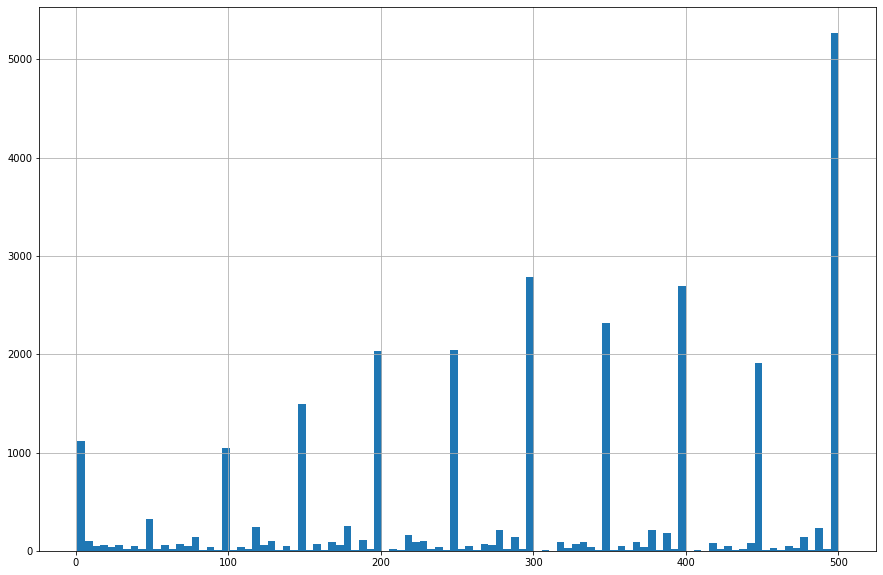

In [14]:
data['Price'].hist(figsize=(15, 10), bins=100, range=(1, 500));

In [15]:
data.query('Price == 0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,unknown,1990,unknown,0,corsa,150000,petrol,opel,unknown
111,0,unknown,2017,manual,0,golf,5000,petrol,volkswagen,unknown
115,0,small,1999,unknown,0,unknown,5000,petrol,volkswagen,unknown
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,unknown,2000,manual,65,corsa,150000,unknown,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,unknown
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,unknown
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


8904 записи с нулевой ценой, они не помогут нам в нашей цели, удалим их

In [16]:
data = data.query('Price != 0')

#### Колонка Power

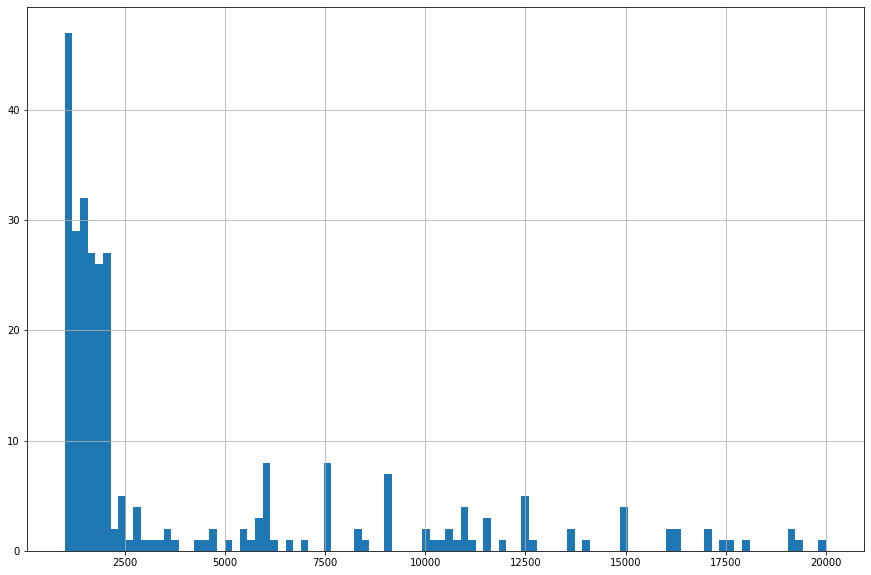

In [17]:
data['Power'].hist(figsize=(15, 10), bins=100, range=(1000, 20000));

По графику видно, что начиная с мощности 2500лс количество автомобилей резко падает, это выбросы

In [18]:
data.query('Power > 2500')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,unknown
19092,9750,wagon,2005,auto,2729,5er,150000,gasoline,bmw,no
25232,10900,bus,2009,manual,10520,caddy,150000,gasoline,volkswagen,no
33952,3740,small,2006,manual,6920,aygo,90000,unknown,toyota,no
44520,2500,convertible,1998,manual,7512,golf,150000,unknown,volkswagen,unknown
...,...,...,...,...,...,...,...,...,...,...
341066,449,unknown,2016,manual,4507,corsa,150000,petrol,opel,no
341320,1899,other,2006,manual,7518,berlingo,125000,petrol,citroen,yes
346639,1300,sedan,2000,manual,12512,carisma,150000,petrol,mitsubishi,unknown
348137,850,sedan,1993,auto,9012,golf,150000,petrol,volkswagen,unknown


Очевидно, что эти данные неадекватны, удалим эти 93 записи.

In [19]:
data = data.query('Power < 2500')

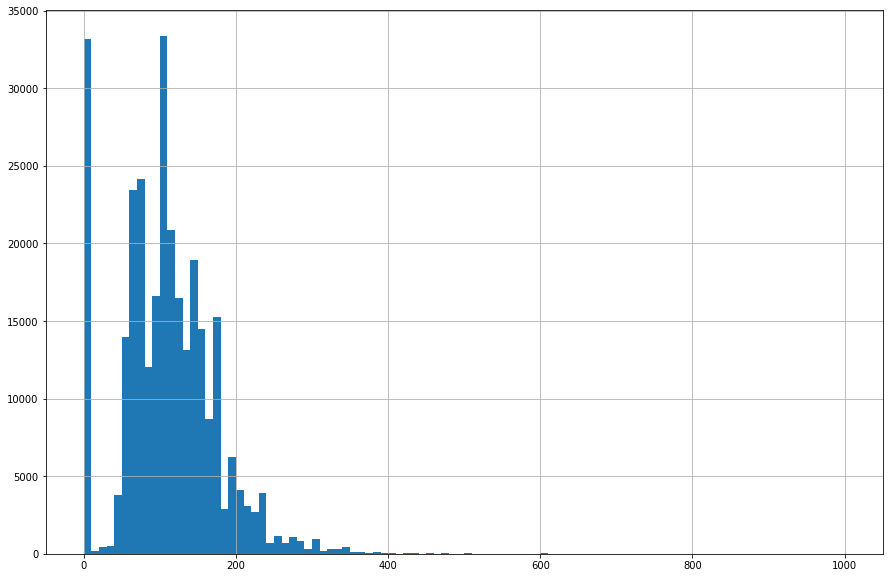

In [20]:
data['Power'].hist(figsize=(15, 10), bins=100, range=(0, 1000));

In [21]:
data.query('Power == 0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016,unknown,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,unknown,opel,no
...,...,...,...,...,...,...,...,...,...,...
354332,7900,bus,2007,manual,0,b_klasse,125000,petrol,mercedes_benz,no
354335,390,small,1997,auto,0,corsa,100000,petrol,opel,yes
354338,180,unknown,1995,unknown,0,unknown,125000,petrol,opel,unknown
354346,2600,unknown,2005,auto,0,c_klasse,150000,unknown,mercedes_benz,unknown


Записи с нулевой мощностью составляют около 9%, удалять такое количество данных слишком расточительно, заменим нули медианными значениями по каждой модели

In [22]:
for model in data['Model'].unique():
    data.loc[(data['Model'] == model) & (data['Power'] == 0), 'Power'] =\
    data.loc[(data['Model'] == model), 'Power'].median()
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes
354365,2200,unknown,2005,unknown,75.0,unknown,20000,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


In [23]:
data.query('Power == 0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
3338,199,unknown,1995,manual,0.0,samara,100000,petrol,lada,unknown
26625,200,unknown,2016,manual,0.0,samara,150000,petrol,lada,unknown
42665,300,small,1997,manual,0.0,samara,50000,petrol,lada,yes
69358,99,unknown,1995,manual,0.0,samara,125000,petrol,lada,unknown
75177,249,unknown,1985,manual,0.0,samara,125000,petrol,lada,unknown
150050,650,wagon,2007,manual,0.0,samara,125000,petrol,lada,unknown
234296,3800,wagon,1978,manual,0.0,serie_1,30000,gasoline,land_rover,unknown
353555,2199,unknown,2016,manual,0.0,samara,70000,unknown,lada,no


Оставшихся значений не так много, их можно удалить

In [24]:
data = data.query('Power != 0')
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes
354365,2200,unknown,2005,unknown,75.0,unknown,20000,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


#### Колонка RegistrationYear

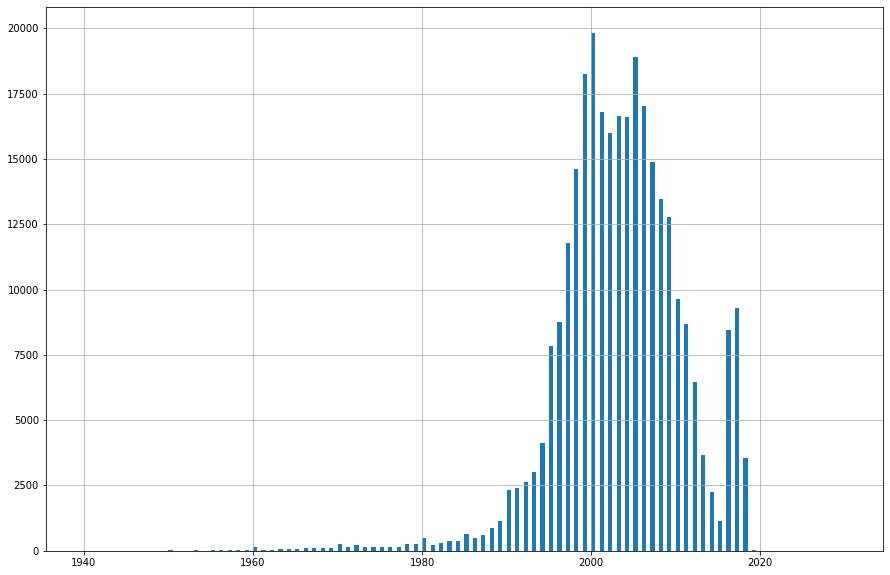

In [25]:
data['RegistrationYear'].hist(figsize=(15, 10), bins=180, range=(1940, 2030));

Основная масса автомобилей зарегестрирована с 1960 по 2018 год

In [26]:
data.query('RegistrationYear < 1960 or RegistrationYear > 2018')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
15,450,small,1910,unknown,60.0,ka,5000,petrol,ford,unknown
1928,7000,suv,1945,manual,48.0,other,150000,petrol,volkswagen,no
2273,1800,convertible,1925,unknown,75.0,unknown,5000,unknown,sonstige_autos,no
3333,10500,sedan,1955,manual,30.0,other,60000,petrol,ford,unknown
6977,135,unknown,1910,unknown,75.0,unknown,5000,unknown,opel,unknown
...,...,...,...,...,...,...,...,...,...,...
351299,5500,bus,1956,manual,37.0,unknown,60000,petrol,sonstige_autos,no
351682,11500,unknown,1800,unknown,16.0,other,5000,petrol,fiat,unknown
353531,6000,sedan,1937,manual,38.0,other,5000,petrol,mercedes_benz,unknown
353961,200,unknown,1910,unknown,75.0,unknown,5000,petrol,sonstige_autos,unknown


Удалим 426 записей вне этого периода

In [27]:
data = data.query('RegistrationYear >= 1960 and RegistrationYear <= 2018')

In [ ]:
data.RegistrationYear.describe()

count    299898.000000
mean       2003.291662
std           7.313768
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2018.000000
Name: RegistrationYear, dtype: float64

### Подготовим выборки

Создадим константную переменную для random_state

In [29]:
RS = 12345

Разобьем данные на обучающую и тестовую выборки в соотношении 3:1

In [30]:
features = data.drop(['Price'], axis=1)
target = data['Price']

features_train_raw, features_test_raw, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RS
) 


print(features_train_raw.shape[0])
print(features_test_raw.shape[0])

224923
74975


### Закодируем данные

In [31]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
data[cat_features].nunique()

VehicleType      9
Gearbox          3
Model          250
FuelType         8
Brand           40
Repaired         3
dtype: int64

Для колонок VehicleType, Gearbox, FuelType, Repaired с небольшим количеством уникальных значений используем технику One-Hot Encoding.

Для колонок Model, Brand используем технику Ordinal Encoding

In [32]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
transformer = make_column_transformer((OneHotEncoder(drop='first'), ohe_columns), remainder='passthrough')
                                      
features_train = pd.DataFrame(transformer.fit_transform(features_train_raw),
                              columns=transformer.get_feature_names(),
                              index=features_train_raw.index
                             )

features_test = pd.DataFrame(transformer.transform(features_test_raw),
                             columns=transformer.get_feature_names(),
                             index=features_test_raw.index
                            )

In [33]:
encoder = OrdinalEncoder()
features_train[['Model', 'Brand']] = encoder.fit_transform(features_train[['Model', 'Brand']])

features_test[['Model', 'Brand']] = encoder.transform(features_test[['Model', 'Brand']])

In [34]:
display(features_train)
display(features_test)

,onehotencoder__x0_convertible,onehotencoder__x0_coupe,onehotencoder__x0_other,onehotencoder__x0_sedan,onehotencoder__x0_small,onehotencoder__x0_suv,onehotencoder__x0_unknown,onehotencoder__x0_wagon,onehotencoder__x1_manual,onehotencoder__x1_unknown,...,onehotencoder__x2_other,onehotencoder__x2_petrol,onehotencoder__x2_unknown,onehotencoder__x3_unknown,onehotencoder__x3_yes,RegistrationYear,Power,Model,Kilometer,Brand
47647,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1998,65.0,42.0,150000,24.0
14497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,2009,160.0,199.0,150000,38.0
181374,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1991,45.0,83.0,150000,24.0
41335,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2010,122.0,116.0,70000,38.0
257359,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1998,101.0,234.0,150000,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177337,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1999,105.0,11.0,125000,2.0
50885,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1998,136.0,211.0,150000,15.0
93535,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1998,75.0,42.0,125000,24.0
83271,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1998,80.0,176.0,150000,9.0


,onehotencoder__x0_convertible,onehotencoder__x0_coupe,onehotencoder__x0_other,onehotencoder__x0_sedan,onehotencoder__x0_small,onehotencoder__x0_suv,onehotencoder__x0_unknown,onehotencoder__x0_wagon,onehotencoder__x1_manual,onehotencoder__x1_unknown,...,onehotencoder__x2_other,onehotencoder__x2_petrol,onehotencoder__x2_unknown,onehotencoder__x3_unknown,onehotencoder__x3_yes,RegistrationYear,Power,Model,Kilometer,Brand
31847,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2010,122.0,80.0,60000,21.0
181900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2011,140.0,221.0,150000,38.0
228923,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2008,116.0,42.0,150000,24.0
8323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1989,101.0,116.0,150000,38.0
134269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2011,140.0,221.0,150000,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280984,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,2006,163.0,29.0,125000,1.0
29990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2004,131.0,170.0,150000,38.0
320436,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2003,192.0,15.0,150000,2.0
996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1997,150.0,15.0,150000,2.0


In [35]:
for column in features_train:
    features_train[column] = features_train[column].astype('int')
for column in features_test:
    features_test[column] = features_test[column].astype('int')

### Вывод

Была проведена предобработка данных:

Удалены неинформативные столбцы с данными, не влияющими на цену:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Пропуски заполнены заглушкой

Удалены дубликаты

Обработаны аномалии:

- Из колонки Price удалены строки с нулевыми значениями (8904 записи)
- Из колонки Power удалены строки с очевидно неадекватными значениями выше 2500 (93 записи) а также заменены медианным по моделям значением записи с нулевой мощностью (32972 записи), также удалены 8 записей, по моделям которых нет данных о мощности
- Из колонки RegistrationYear удалены записи с годом регистрации до 1960 и после 2018 (426 записей)

Данные разбиты на обучающую и тестовую выборки в соотношении 3:1

Колонки VehicleType, Gearbox, FuelType, Repaired с небольшим количеством уникальных значений закодированы техникой One-Hot Encoding.

Колонки Model, Brand закодированы техникой Ordinal Encoding

## Обучение моделей

### Обучим модель линейной регрессии

Так как модель линейной регрессии плохо совместима с ОЕ кодированием, эти признаки удалим для ее обучения

In [36]:
lr_features_train = features_train.drop(['Model', 'Brand'], axis=1)
lr_features_test = features_test.drop(['Model', 'Brand'], axis=1)

In [37]:
model_lr = LinearRegression()
params = {
    'fit_intercept' :[True, False]
}
grid_lr = RandomizedSearchCV(model_lr,
                             params,
                             n_iter=2,
                             cv=5,
                             n_jobs=-1,
                             scoring='neg_root_mean_squared_error',
                             random_state=RS)
grid_lr.fit(lr_features_train, target_train)
train_rmse_lr = abs(grid_lr.best_score_)
lr_fit_time = grid_lr.cv_results_['mean_fit_time'][grid_lr.best_index_]
lr_pred_time = grid_lr.cv_results_['mean_score_time'][grid_lr.best_index_]

print('Лучшие параметры: ', grid_lr.best_params_)
print('RMSE: ', train_rmse_lr)
print('Время обучения: ', lr_fit_time)
print('Время предсказания: ', lr_pred_time)

Лучшие параметры:  {'fit_intercept': True}
RMSE:  3111.148527975636
Время обучения:  0.3809495449066162
Время предсказания:  0.05699615478515625


### Обучим модель решающего дерева

In [38]:
model_dtr = DecisionTreeRegressor(random_state=RS)
params = {'max_depth': [1, 3, 5, 7, 9],
              'max_features': [2, 3, 4, 5],
              'min_samples_split': [4, 8, 12],
              'min_samples_leaf': [4, 8, 12]
             }

grid_dtr = RandomizedSearchCV(model_dtr,
                              params,
                              n_iter=20,
                              cv=5,
                              n_jobs=-1,
                              scoring='neg_root_mean_squared_error',
                              random_state=RS)
grid_dtr.fit(features_train, target_train)
train_rmse_dtr = abs(grid_dtr.best_score_)
dtr_fit_time = grid_dtr.cv_results_['mean_fit_time'][grid_dtr.best_index_]
dtr_pred_time = grid_dtr.cv_results_['mean_score_time'][grid_dtr.best_index_]

print('Лучшие параметры: ', grid_dtr.best_params_)
print('RMSE: ', train_rmse_dtr)
print('Время обучения: ', dtr_fit_time)
print('Время предсказания: ', dtr_pred_time)

Лучшие параметры:  {'min_samples_split': 8, 'min_samples_leaf': 12, 'max_features': 5, 'max_depth': 9}
RMSE:  2708.523591773069
Время обучения:  0.12636423110961914
Время предсказания:  0.007266473770141601


### Обучим модель случайного леса

In [39]:
model_rfr = RandomForestRegressor(random_state=RS)
params = {'max_depth': [1, 3, 5, 7, 9, 11, 13, 15],
          'n_estimators': [50, 100, 150, 200, 250, 300],
          'max_features': [2, 4, 6, 8, 10],
          'min_samples_split': [2, 4, 8, 12, 16, 18, 20],
          'min_samples_leaf': [2, 4, 8, 12, 16, 18, 20]
         }

grid_rfr = RandomizedSearchCV(model_rfr,
                              params,
                              n_iter=10,
                              cv=5,
                              n_jobs=-1,
                              scoring='neg_root_mean_squared_error',
                              random_state=RS)
grid_rfr.fit(features_train, target_train)
train_rmse_rfr = abs(grid_rfr.best_score_)
rfr_fit_time = grid_rfr.cv_results_['mean_fit_time'][grid_rfr.best_index_]
rfr_pred_time = grid_rfr.cv_results_['mean_score_time'][grid_rfr.best_index_]

print('Лучшие параметры: ', grid_rfr.best_params_)
print('RMSE: ', train_rmse_rfr)
print('Время обучения: ', rfr_fit_time)
print('Время предсказания: ', rfr_pred_time)

Лучшие параметры:  {'n_estimators': 300, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 10, 'max_depth': 15}
RMSE:  1798.7128749899093
Время обучения:  57.482599067687985
Время предсказания:  1.6890113830566407


### Обучим модель CatBoost

Так как CatBoost работает с категориальными признаками, вернемся к изначальным незакодированным данным.

In [40]:
model_cbr = CatBoostRegressor(cat_features=cat_features,
                              verbose=False,
                              random_state=RS)
params = {
    'depth': range(3, 9, 2),
    'iterations': range(500, 1000, 100)
}
cv = KFold(n_splits=5, shuffle=True, random_state=RS)

grid_cbr = RandomizedSearchCV(estimator=model_cbr,
                              param_distributions=params,
                              n_iter=5,
                              cv=cv,
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1,
                              random_state=RS
                             )
grid_cbr.fit(features_train_raw, target_train)
train_rmse_cbr = abs(grid_cbr.best_score_)
cbr_fit_time = grid_cbr.cv_results_['mean_fit_time'][grid_cbr.best_index_]
cbr_pred_time = grid_cbr.cv_results_['mean_score_time'][grid_cbr.best_index_]

print('Лучшие параметры: ', grid_cbr.best_params_)
print('RMSE: ', train_rmse_cbr)
print('Время обучения: ', cbr_fit_time)
print('Время предсказания: ', cbr_pred_time)

Лучшие параметры:  {'iterations': 600, 'depth': 7}
RMSE:  1683.155711767291
Время обучения:  119.32789855003357
Время предсказания:  0.3145939350128174


### Обучим модель LightGBM

In [41]:
model_lgb = lgb.LGBMRegressor(random_state=RS)
params = {
    'max_depth': [3, 5, 7, 9],
    'num_iterations': [500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.001, 0.01, 0.1]
}
cv = KFold(n_splits=5, shuffle=True, random_state=RS)

grid_lgb = RandomizedSearchCV(estimator=model_lgb,
                              param_distributions=params,
                              n_iter=5,
                              cv=cv,
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1,
                              random_state=RS
                             )
grid_lgb.fit(features_train, target_train)
train_rmse_lgb = abs(grid_lgb.best_score_)
lgb_fit_time = grid_lgb.cv_results_['mean_fit_time'][grid_lgb.best_index_]
lgb_pred_time = grid_lgb.cv_results_['mean_score_time'][grid_lgb.best_index_]

print('Лучшие параметры: ', grid_lgb.best_params_)
print('RMSE: ', train_rmse_lgb)
print('Время обучения: ', lgb_fit_time)
print('Время предсказания: ', lgb_pred_time)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

Лучшие параметры:  {'num_iterations': 900, 'max_depth': 7, 'learning_rate': 0.1}
RMSE:  1669.6788793261526
Время обучения:  27.323340463638306
Время предсказания:  4.2991705417633055


### Вывод

Обучены на тренировочной выборке с кросс-валидацией модели:

- LinearRegression
- DecisionTreeRegressor
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor

Для этих моделей получены данные о времени обучения и предсказания и метрики RMSE, которые будут проанализированы в следующем блоке

## Анализ моделей

### Соберем все данные в датафрейм

In [42]:
analysis = pd.DataFrame({
    'Модель': ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'],
    'RMSE на трейне': [train_rmse_lr, train_rmse_dtr, train_rmse_rfr, train_rmse_cbr, train_rmse_lgb],
    'Обучение, с': [lr_fit_time, dtr_fit_time, rfr_fit_time, cbr_fit_time, lgb_fit_time],
    'Предсказание, с': [lr_pred_time, dtr_pred_time, rfr_pred_time, cbr_pred_time, lgb_pred_time],
})

analysis

,Модель,RMSE на трейне,"Обучение, с","Предсказание, с"
0,LinearRegression,3111.148528,0.380950,0.056996
1,DecisionTreeRegressor,2708.523592,0.126364,0.007266
2,RandomForestRegressor,1798.712875,57.482599,1.689011
3,CatBoostRegressor,1683.155712,119.327899,0.314594
4,LGBMRegressor,1669.678879,27.323340,4.299171


### Вывод

Самую высокую метрику RMSE на тестовой выборке показала модель LightGBM (1670), также допустимые метрики показали еще две модели - CatBoost (1683) и случайный лес (1799).

Самая быстрая из них - модель LightGBM (обучение: 27,3с, предсказание: 4,3с), также небольшое время обучения показала модель случайного леса (обучение: 57,5с, предсказание: 1,7с). Самая долгообучаемая модель - модель CatBoost (обучение: 119,3с, предсказание: 0,3с).

Наиболее выгодно выглядит модель LightGBM, проверим ее на тестовой выборке.

## Проверка модели LightGBM

In [47]:
best_model = lgb.LGBMRegressor(num_iterations=900,
                               max_depth=7,
                               learning_rate=0.1,
                               random_state=RS)

best_model.fit(features_train, target_train)
best_predictions = best_model.predict(features_test)
best_rmse = mean_squared_error(target_test, best_predictions)**0.5
print('RMSE на тестовой выборке: ', best_rmse)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE на тестовой выборке:  1668.9551564967794


## Общий вывод

Была проведена предобработка данных:

- Удалены неинформативные столбцы с данными, не влияющими на цену
- Удалены дубликаты
- Обработаны аномалии
- Колонки с небольшим количеством уникальных значений закодированы техникой One-Hot Encoding.
- Остальные колонки закодированы техникой Ordinal Encoding

Обучены на тренировочной выборке с кросс-валидацией модели:

- LinearRegression
- DecisionTreeRegressor
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor

Подобраны наилучшие гиперпараметры, модели с которыми далее были проверены на тесте

Данные обучения и тестов приведены в таблице:

In [43]:
analysis

,Модель,RMSE на трейне,"Обучение, с","Предсказание, с"
0,LinearRegression,3111.148528,0.380950,0.056996
1,DecisionTreeRegressor,2708.523592,0.126364,0.007266
2,RandomForestRegressor,1798.712875,57.482599,1.689011
3,CatBoostRegressor,1683.155712,119.327899,0.314594
4,LGBMRegressor,1669.678879,27.323340,4.299171


Наилучшей была выбрана модель LightGBM с самым высоким качеством и самым коротким временем обучения и предсказания.

Эта модель была проверена на тестовой выборке и показала метрику RMSE равную 1669